In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.optimizer import SPSA
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
# for logging & visualization
import logging
from classifiers.callback import CostParamStorage, ParamsStopping
from torch.utils.tensorboard import SummaryWriter
from classifiers.visualization import Plot_Data, Plot_Log_From_SPSA, Plot_SVM, compare_svm_and_qasvm

if IBMQ.active_account() is None:
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='reservations')
backend = provider.get_backend('ibmq_toronto')
backend

<IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-kaist', group='internal', project='reservations')>

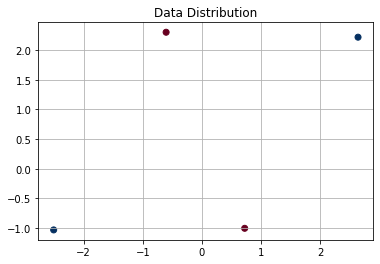

In [4]:
X, y = Example_4x2(True)()
Plot_Data(X, y).plot()

In [5]:
quantum_instance = QuantumInstance(backend=AerSimulator.from_backend(backend), initial_layout=Qasvm_Mapping_4x2(backend), optimization_level=2, seed_transpiler=10, measurement_error_mitigation_cls=CompleteMeasFitter)
quantum_instance_real = QuantumInstance(backend=backend, initial_layout=Qasvm_Mapping_4x2(backend), optimization_level=2, seed_transpiler=10, measurement_error_mitigation_cls=CompleteMeasFitter)
#quantum_instance = QuantumInstance(backend=AerSimulator(), measurement_error_mitigation_cls=CompleteMeasFitter)
var_form = RealAmplitudes(2, reps=1)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
print(qasvm.first_order_circuit.depth())

71
75


In [6]:
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [7]:
optimizer = SPSA(qasvm, blocking=False)
storage = CostParamStorage(interval=1)
epochs = 2**7
last_avg = 2**4
param_list = list()

from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter()
storage(0, qasvm.parameters, qasvm.cost_fn, None, True)

from tqdm.notebook import tqdm
for epoch in tqdm(range(int(epochs/1))):
    if epoch>=epochs-last_avg:
        optimizer.step(storage)
        storage.add_writer(writer)
        optimizer._nfev+=1
        param_list.append(list(qasvm.parameters.values()))
    else:
        if epoch%10==0:
            optimizer.step(storage)
            storage.add_writer(writer)
            optimizer._nfev+=1
            param_list.append(list(qasvm.parameters.values()))
        else:
            optimizer.step()
            param_list.append(list(qasvm.parameters.values()))
    if epoch==int(epochs/2):
        print(optimizer._nfev)
        optimizer._nfev=0
        qasvm._quantum_instance=quantum_instance_real

qasvm.parameters = storage.last_avg(last_avg)
print(optimizer._nfev)

  0%|          | 0/128 [00:00<?, ?it/s]

137


/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/u

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/u

KeyboardInterrupt: 

svm = BinarySVM(kernel=Kernel('SingleQubit'), C=None, k=10, mutation='REDUCED_QASVM')
svm.fit(X, y)
compare_svm_and_qasvm(svm, qasvm, 1)

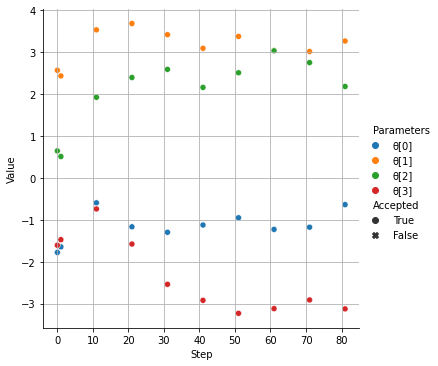

In [9]:
storage.plot_params(method='relplot')

<AxesSubplot:xlabel='Step', ylabel='Cost'>

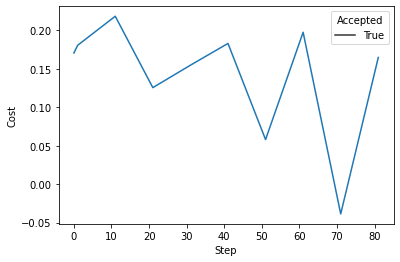

In [10]:
storage.plot(method='mpl')

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)


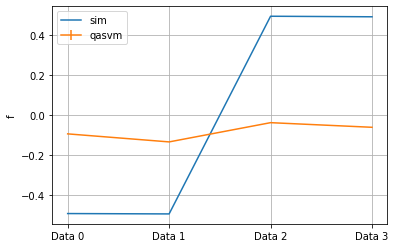

In [8]:
svm = BinarySVM(kernel=Kernel('SingleQubit'), C=None, k=10, mutation='REDUCED_QASVM')
svm.fit(X, y)
compare_svm_and_qasvm(svm, qasvm, 1)